# PUBG Finish Placement Prediction

In [92]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
random.seed(16)

In [93]:
# Read data to dataframe
df = pd.read_csv("data/train_V2.csv")
df_types = pd.read_csv("data/types.csv")

In [94]:
# Initial settings
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('display.width',2000)

plt.rcParams['figure.dpi'] = 100

In [95]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    return df

In [96]:
# Reducing memory usage
df = reduce_mem_usage(df)
df_types = reduce_mem_usage(df_types)

In [97]:
# Function to split data into two sets
# Data is grouped by "matchId" which means that games are not mixed up between sets.

def split_into_train_test_sets(df, test_set_size=0.2):
    match_ids = df['matchId'].unique().tolist()
    train_size = int(len(match_ids) * (1 - test_set_size))
    train_match_ids = random.sample(match_ids, train_size)

    train = df[df['matchId'].isin(train_match_ids)]
    test = df[-df['matchId'].isin(train_match_ids)]
    
    return train, test

## Cleaning data



#### Incorrect Match

In the data set there is one row of data where the variable we are going to predict is missing. We need to drop it.

In [98]:
df[df.isnull().any(axis=1)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,0,0,0,0.0,9,solo-fpp,1,1,1574,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [100]:
df = df[pd.notnull(df['winPlacePerc'])]
df[df.isnull().any(axis=1)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc


Row where winPlacePerc is missing is gone.

#### Removing custom games
- flaretpp
- flarefpp
- crashtpp
- crashfpp

In [102]:
df[(df['matchType'] == "flaretpp") |
   (df['matchType'] == "flarefpp") | 
   (df['matchType'] == "crashtpp") | 
   (df['matchType'] == "crashfpp")].head(5)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
1093,c8ed6a171536e3,84748458aba82a,d4f1811cf6a04b,1,3,187.3750,0,1,6,27,0,1,1,0.800781,904,crashfpp,50,45,1500,0,0.00,0,0.0,0,0,1342.000000,1,0,0.489746
1207,fb785deb59f2bc,4438f77ac9f2e6,33d976b454b843,0,4,577.0000,7,2,4,6,0,4,2,208.500000,1947,flaretpp,26,25,1500,1,2548.00,0,0.0,0,1,2564.000000,6,0,0.799805
1276,d3c4dd2e585d21,6af9bb6b56b722,16e6befa897b44,0,0,0.0000,0,0,0,88,0,0,0,0.000000,892,crashfpp,47,45,1500,0,0.00,0,0.0,0,0,0.000000,0,0,0.000000
1524,b0fbbe07014fcd,7ce6194a5dd609,e330f44c528e6f,0,0,20.9375,0,0,0,55,0,0,0,0.000000,2031,flarefpp,17,17,1500,0,0.00,0,0.0,0,0,13.640625,1,0,0.062500
1790,28390372a2cc4f,c529d05da4597b,be945f2803814a,0,0,0.0000,0,0,0,76,0,0,0,0.000000,915,crashfpp,50,50,1500,0,393.75,0,0.0,0,0,459.500000,0,0,0.204102


In [103]:
df.drop(df[(df['matchType'] == "flaretpp") |
           (df['matchType'] == "flarefpp") | 
           (df['matchType'] == "crashtpp") | 
           (df['matchType'] == "crashfpp")]
        .index, inplace=True)

#### AFKs and cheaters

Removing players who haven't moved throughout the match. We are trying to identify cheaters and AFKs.

In [104]:
df[df['walkDistance'] == 0].head(5)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
29,ac5b57ff39979c,857cc55b2b6001,e019e04dee4f19,0,0,0.0,0,0,0,87,0,0,0,0.0,1530,duo,46,44,1534,0,0.0,0,0.0,0,0,0.0,0,0,0.000000
116,6adb021f5165ff,58e5500bd40898,de5c692fe25a73,0,0,0.0,0,0,0,68,311,0,0,0.0,1414,duo,41,36,0,0,0.0,0,0.0,0,0,0.0,0,847,0.000000
151,a2bbe20aa8789d,926e8a09bab249,e36e4203ed4831,0,0,0.0,0,0,0,92,309,0,0,0.0,1377,duo,48,41,-1,0,0.0,0,0.0,0,0,0.0,0,765,0.000000
237,baaa694658e085,d034728f22cff7,fa71620624d3e7,0,0,0.0,0,0,0,94,1397,0,0,0.0,1358,squad-fpp,29,26,-1,0,0.0,0,0.0,0,0,0.0,0,1510,0.000000
283,3ab8128e6bcbe6,bb52a209f2e938,aabd2650b129e2,0,0,0.0,0,0,0,84,0,0,0,0.0,1797,duo,48,47,1500,0,0.0,0,0.0,0,0,0.0,0,0,0.127686


In [105]:
df.drop(df[df['walkDistance'] == 0].index, inplace=True)

#### Potential cheats
Removing players who traveled great distances (potential speed cheat)
- walked more than 10km
- rode more than 30km
- swam more than 2km

In [106]:
df[['walkDistance', 'rideDistance', 'swimDistance']].describe()

,walkDistance,rideDistance,swimDistance
count,4.337720e+06,4.337720e+06,4337720.0
mean,NaN,NaN,NaN
std,NaN,NaN,NaN
min,1.000166e-04,0.000000e+00,0.0
25%,1.722500e+02,0.000000e+00,0.0
50%,7.335000e+02,0.000000e+00,0.0
75%,2.010000e+03,7.756250e+01,0.0
max,2.577600e+04,4.070400e+04,3824.0


In [107]:
df.drop(df[df['walkDistance'] >= 10000].index, inplace=True)
df.drop(df[df['rideDistance'] >= 30000].index, inplace=True)
df.drop(df[df['swimDistance'] >= 2000].index, inplace=True)

##### Large Number of Kills
Removing players who have more than 40 kills.

Let's plot the total kills for every player first.

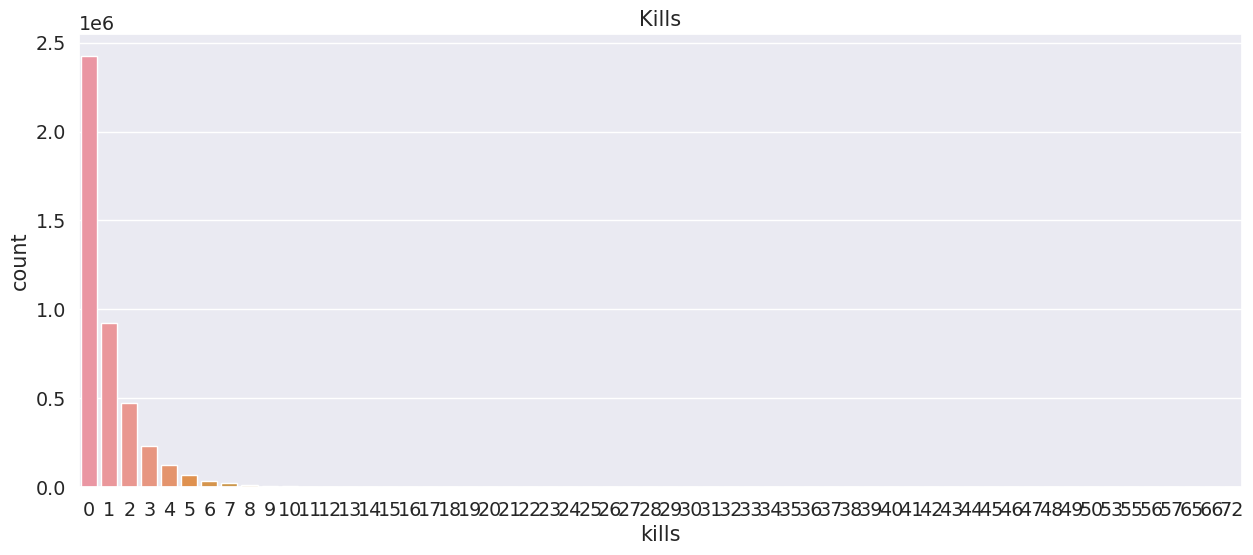

In [108]:
plt.figure(figsize=(15,6))
sns.countplot(data=df, x=df['kills']).set_title('Kills')
plt.show()

In [109]:
display(df[df['kills'] > 40].shape)

(32, 29)

In [110]:
df[df['kills'] >= 40].head(5)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
156599,746aa7eabf7c86,5723e7d8250da3,f900de1ec39fa5,21,0,5480.0,0,12,7,4,0,48,6,81.9375,1798,normal-solo-fpp,11,11,1500,0,0.0,0,0.0,0,0,23.703125,61,0,0.700195
160254,15622257cb44e2,1a513eeecfe724,db413c7c48292c,1,0,4032.0,0,40,0,1,1000,42,5,266.2500,844,normal-squad-fpp,8,8,-1,0,0.0,0,0.0,1,0,718.500000,16,1500,1.000000
334400,810f2379261545,7f3e493ee71534,f900de1ec39fa5,20,0,6616.0,0,13,5,1,0,65,7,73.8750,1798,normal-solo-fpp,11,11,1500,0,0.0,0,0.0,0,0,1036.000000,60,0,1.000000
672993,da31f191ace8ed,ce9a3c4950a8f2,17dea22cefe62a,10,0,5792.0,0,5,2,1,0,57,5,104.1875,1798,normal-duo-fpp,15,12,1500,0,0.0,0,0.0,0,0,24.265625,56,0,1.000000
770454,2ade4369bccd12,9f9e64a3db8384,e024bf51bf1799,12,0,5556.0,0,7,4,1,0,55,6,74.8125,1798,normal-solo-fpp,19,18,1500,0,0.0,0,0.0,0,0,85.562500,66,0,1.000000


It doesn't look like there are too many outliers. We decide to remove those.

In [111]:
df.drop(df[df['kills'] >= 40].index, inplace=True)

#### Potential Aim Bot

We will create a new feature 'headshotRate' and plot of it

<Figure size 1200x400 with 0 Axes>

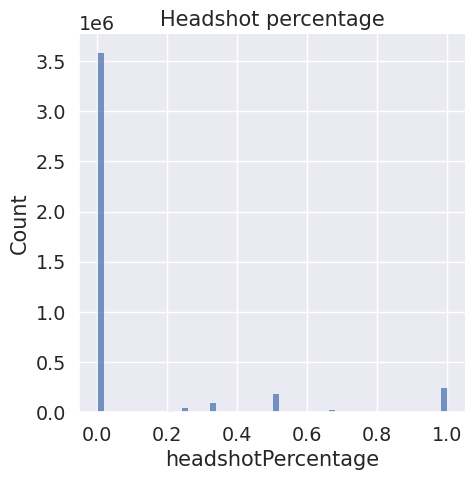

In [112]:
df['headshotPercentage'] = df['headshotKills'] / df['kills']
df['headshotPercentage'] = df['headshotPercentage'].fillna(0)

plt.figure(figsize=(12, 4))
sns.displot(df['headshotPercentage'], bins=50)
plt.title('Headshot percentage')
plt.show()

Not every player with 100% headshot has to be cheater. They might be just goog players.n
That's why we will remove only players who have more than 10 kills and 100% headshots.

In [113]:
df[(df['headshotKills'] == df['kills']) & (df['kills'] >= 10)].head(5)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,headshotPercentage
281570,ab9d7168570927,add05ebde0214c,e016a873339c7b,2,3,1212.0,8,10,0,1,0,10,4,159.25,1423,squad-fpp,27,25,1564,1,0.0,0,0.0,0,0,2940.0,5,0,0.846191,1.0
346124,044d18fc42fc75,fc1dbc2df6a887,628107d4c41084,3,5,1620.0,13,11,3,1,1424,11,2,633.50,1727,squad,27,26,-1,3,4720.0,0,0.0,0,0,3422.0,8,1560,1.000000,1.0
871244,e668a25f5488e3,5ba8feabfb2a23,f6e6581e03ba4f,0,4,1365.0,9,13,0,1,1579,13,2,353.75,1255,squad,27,27,-1,0,0.0,0,0.0,0,0,2104.0,5,1587,1.000000,1.0
908815,566d8218b705aa,a9b056478d71b2,3a41552d553583,2,5,1535.0,10,10,3,1,1393,10,3,533.00,1838,squad-fpp,28,24,-1,0,5188.0,0,0.0,2,0,2760.0,7,1519,0.962891,1.0
963463,1bd6fd288df4f0,90584ffa22fe15,ba2de992ec7bb8,2,6,1355.0,12,10,2,1,1543,10,2,277.00,1417,squad,27,26,-1,0,1018.0,0,0.0,0,0,2458.0,4,1562,1.000000,1.0


In [114]:
df.drop(df[(df['headshotKills'] == df['kills']) & (df['kills'] >= 10)].index, inplace=True)

## Train data and test data

Source of data: https://www.kaggle.com/c/pubg-finish-placement-prediction

Our data contains around 4.5 millions rows.

We are going to split it into two sets:
- train set,
- test set

In [115]:
df_train, df_test = split_into_train_test_sets(df, 0.2)

### Train data


Brief look at the train data

In [116]:
df_train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,headshotPercentage
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,1241,0,0,0.00000,1306,squad-fpp,28,26,-1,0,0.000000,0,0.000000,0,0,244.75,1,1466,0.444336,0.0
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,0,0,0,0.00000,1777,squad-fpp,26,25,1484,0,0.004501,0,11.039062,0,0,1434.00,5,0,0.640137,0.0
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,0,0,0,0.00000,1318,duo,50,47,1491,0,0.000000,0,0.000000,0,0,161.75,2,0,0.775391,0.0
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,0,0,0,0.00000,1436,squad-fpp,31,30,1408,0,0.000000,0,0.000000,0,0,202.75,3,0,0.166748,0.0
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,0,1,1,58.53125,1424,solo-fpp,97,95,1560,0,0.000000,0,0.000000,0,0,49.75,2,0,0.187500,0.0


In [117]:
df_train.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,headshotPercentage
count,3.469847e+06,3.469847e+06,3.469847e+06,3.469847e+06,3.469847e+06,3.469847e+06,3.469847e+06,3.469847e+06,3.469847e+06,3.469847e+06,3.469847e+06,3.469847e+06,3.469847e+06,3.469847e+06,3.469847e+06,3.469847e+06,3469847.000,3.469847e+06,3469847.0,3.469847e+06,3.469847e+06,3.469847e+06,3.469847e+06,3.469847e+06,3.469847e+06,3.469847e+06
mean,2.383901e-01,1.131767e+00,NaN,6.718607e-01,2.316344e-01,1.402385e+00,4.682020e+01,5.064362e+02,9.446624e-01,5.557087e-01,NaN,1.580254e+03,4.450200e+01,4.304152e+01,8.922022e+02,1.682633e-01,NaN,3.084286e-03,NaN,2.396071e-02,7.964328e-03,NaN,3.734484e+00,6.076616e+02,NaN,1.054396e-01
std,5.927108e-01,1.727558e+00,NaN,1.153240e+00,6.027012e-01,2.705222e+00,2.705407e+01,6.284574e+02,1.561952e+00,7.132730e-01,NaN,2.572401e+02,2.377867e+01,2.321655e+01,7.368644e+02,4.768281e-01,NaN,6.590024e-02,NaN,1.680334e-01,9.259659e-02,NaN,2.415307e+00,7.404351e+02,0.000000e+00,2.628985e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.330000e+02,2.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,0.000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.000166e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.367000e+03,2.800000e+01,2.700000e+01,-1.000000e+00,0.000000e+00,0.000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.722500e+02,2.000000e+00,0.000000e+00,2.143555e-01,0.000000e+00
50%,0.000000e+00,0.000000e+00,8.818750e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.438000e+03,3.000000e+01,3.000000e+01,1.444000e+03,0.000000e+00,0.000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,7.340000e+02,3.000000e+00,0.000000e+00,4.680176e-01,0.000000e+00
75%,0.000000e+00,2.000000e+00,1.897500e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.000000e+01,1.174000e+03,1.000000e+00,1.000000e+00,2.231250e+01,1.851000e+03,4.900000e+01,4.700000e+01,1.500000e+03,0.000000e+00,81.625,0.000000e+00,0.0,0.000000e+00,0.000000e+00,2.009000e+03,5.000000e+00,1.495000e+03,7.500000e-01,0.000000e+00
max,1.700000e+01,3.300000e+01,4.240000e+03,3.900000e+01,2.700000e+01,7.300000e+01,1.010000e+02,2.170000e+03,3.900000e+01,1.800000e+01,1.094000e+03,2.237000e+03,1.000000e+02,1.000000e+02,5.910000e+03,3.200000e+01,29424.000,1.800000e+01,1980.0,1.200000e+01,5.000000e+00,9.984000e+03,2.360000e+02,2.013000e+03,1.000000e+00,1.000000e+00


### Test data

In [118]:
df_test.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,headshotPercentage
7,311b84c6ff4390,eaba5fcb7fc1ae,292611730ca862,0,0,8.539062,0,0,0,48,1000,0,0,0.000000,1967,solo-fpp,96,92,-1,0,2004.0,0,0.00000,0,0,1089.00,6,1500,0.736816,0.00
19,71cbdbc3b263e5,7b61f74b51906c,a329ac99449ad7,0,1,65.250000,0,0,1,48,1349,0,0,0.000000,1322,squad-fpp,30,28,0,0,0.0,0,20.84375,0,0,3310.00,3,1479,0.931152,0.00
28,f9473c4f1cfdc4,8483976f3ba230,6057f846f3ed12,0,6,345.500000,2,1,1,6,0,4,1,105.187500,1339,squad-fpp,28,28,1339,0,0.0,0,0.00000,0,0,3856.00,4,0,0.962891,0.25
35,47143f942503e0,e17a8867a393ec,bc2faecb77e5ec,0,0,136.875000,0,0,0,37,0,1,1,22.828125,1425,solo-fpp,96,94,1500,0,0.0,0,0.00000,0,0,270.75,1,0,0.347412,0.00
40,ffd9e56f13438e,8df2112760f9e2,3f8b160eeee685,0,1,61.906250,1,0,1,31,0,1,1,48.406250,1303,squad,26,25,1472,0,529.0,0,0.00000,0,0,327.25,2,0,0.320068,0.00


In [119]:
df_test.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,headshotPercentage
count,867565.000000,867565.000000,867565.000,867565.000000,867565.000000,867565.000000,867565.000000,867565.000000,867565.000000,867565.000000,867565.000000,867565.000000,867565.000000,867565.000000,867565.000000,867565.000000,867565.0000,867565.000000,867565.0,867565.000000,867565.000000,867565.0000,867565.000000,867565.000000,867565.000000,867565.000000
mean,0.238522,1.131575,NaN,0.675299,0.231425,1.392457,46.833276,515.209303,0.940653,0.556460,NaN,1580.545062,44.283254,42.829447,880.640411,0.169433,NaN,0.003108,NaN,0.023577,0.008021,NaN,3.720321,618.834212,NaN,0.105714
std,0.587974,1.724802,NaN,1.147718,0.600599,2.686267,27.049054,629.828682,1.542626,0.714488,NaN,257.405717,23.582118,23.000790,738.636207,0.476911,NaN,0.065496,NaN,0.165959,0.093134,NaN,2.352038,742.563683,0.000000,0.263227
min,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,312.000000,2.000000,1.000000,-1.000000,0.000000,0.0000,0.000000,0.0,0.000000,0.000000,0.0001,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,23.000000,0.000000,0.000000,0.000000,0.000000,1367.000000,28.000000,27.000000,-1.000000,0.000000,0.0000,0.000000,0.0,0.000000,0.000000,171.7500,2.000000,0.000000,0.214355,0.000000
50%,0.000000,0.000000,88.750,0.000000,0.000000,0.000000,47.000000,0.000000,0.000000,0.000000,0.000000,1438.000000,30.000000,30.000000,1438.000000,0.000000,0.0000,0.000000,0.0,0.000000,0.000000,731.5000,3.000000,0.000000,0.466797,0.000000
75%,0.000000,2.000000,189.625,1.000000,0.000000,2.000000,70.000000,1178.000000,1.000000,1.000000,22.296875,1851.000000,49.000000,47.000000,1500.000000,0.000000,59.6875,0.000000,0.0,0.000000,0.000000,2011.0000,5.000000,1497.000000,0.750000,0.000000
max,17.000000,23.000000,4080.000,26.000000,23.000000,80.000000,100.000000,2154.000000,38.000000,11.000000,1000.000000,2218.000000,100.000000,100.000000,5820.000000,39.000000,28448.0000,11.000000,1960.0,4.000000,3.000000,9992.0000,95.000000,2002.000000,1.000000,1.000000


### Data Fields Descriptions


In [120]:
print(df_types)

         Data field                                        Description     Type
0                Id                                        Player's Id   object
1           groupId              ID to identify a group within a match   object
2           matchId                               ID to identify match   object
3         matchType  String identifing the game mode that the data ...   object
4           assists  Number of enemy players this player damaged th...    int64
5            boosts                         Number of boost items used    int64
6       damageDealt                                 Total damage dealt  float64
7             DBNOs                    Number of enemy players knocked    int64
8     headshotKills      Number of enemy players killed with headshots    int64
9             heals                       Number of healing items used    int64
10        killPlace  Ranking in match of number of enemy players ki...    int64
11       killPoints             Kills-ba

We have total 28 predictors where 24 of them is numerical. Id, groupId, matchId and matchType are objects. The three ids identify the players information of each group in each match the participated. The match type indicates one of the 16 game types.

In [121]:
print(df_train["matchType"].unique())

['squad-fpp' 'duo' 'solo-fpp' 'squad' 'duo-fpp' 'solo' 'normal-squad-fpp'
 'normal-solo-fpp' 'normal-duo-fpp' 'normal-duo' 'normal-squad'
 'normal-solo']


Players playing solo-match have their own placement, while the players from the same group share the same placement.

## Looking for best strategy

### Correlation of feature 

A correlation matrix is a table showing correlation coefficients between variables. Each cell in the table shows the correlation between two variables.

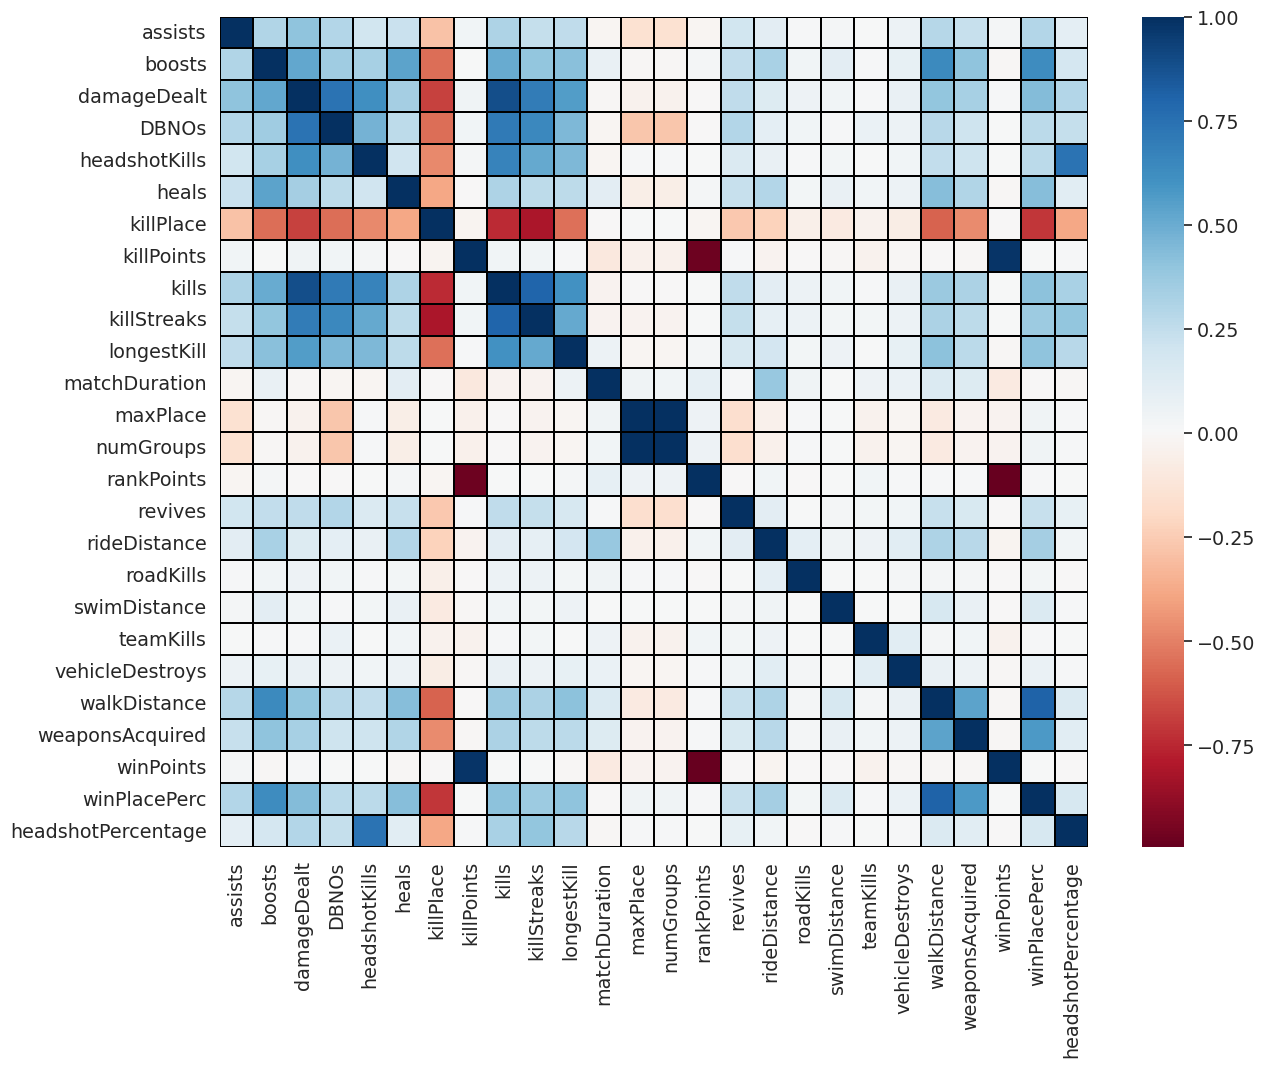

In [122]:
# We do not use columns containing Id and matchType. Only numerical values.
cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType']
cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
corr = df[cols_to_fit].corr()

plt.figure(figsize=(14,11))
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    linecolor='black',
    linewidths=0.1,
    cmap="RdBu"
)
plt.show()

As we can see there are some pairs of value that are highly correlated. It is possible that the highly correlated variables such as might be the most important features in predicting winPlacePerc. 

Pairs with correlation >= 0.45:

In [123]:
corr_pairs = corr.unstack().sort_values(ascending=False).drop_duplicates()
corr_pairs[corr_pairs >= 0.45]

assists             assists          1.000000
maxPlace            numGroups        0.998236
winPoints           killPoints       0.983452
damageDealt         kills            0.887425
winPlacePerc        walkDistance     0.810390
kills               killStreaks      0.803082
damageDealt         DBNOs            0.737639
headshotPercentage  headshotKills    0.737256
kills               DBNOs            0.709956
killStreaks         damageDealt      0.701581
kills               headshotKills    0.671712
killStreaks         DBNOs            0.644889
boosts              walkDistance     0.637142
winPlacePerc        boosts           0.632603
headshotKills       damageDealt      0.610699
kills               longestKill      0.603579
weaponsAcquired     winPlacePerc     0.573229
damageDealt         longestKill      0.563338
weaponsAcquired     walkDistance     0.537947
boosts              heals            0.532803
                    damageDealt      0.521317
killStreaks         longestKill   

#### Highlt correlated

Let's take a closer look at 6 most correlated variables with the target

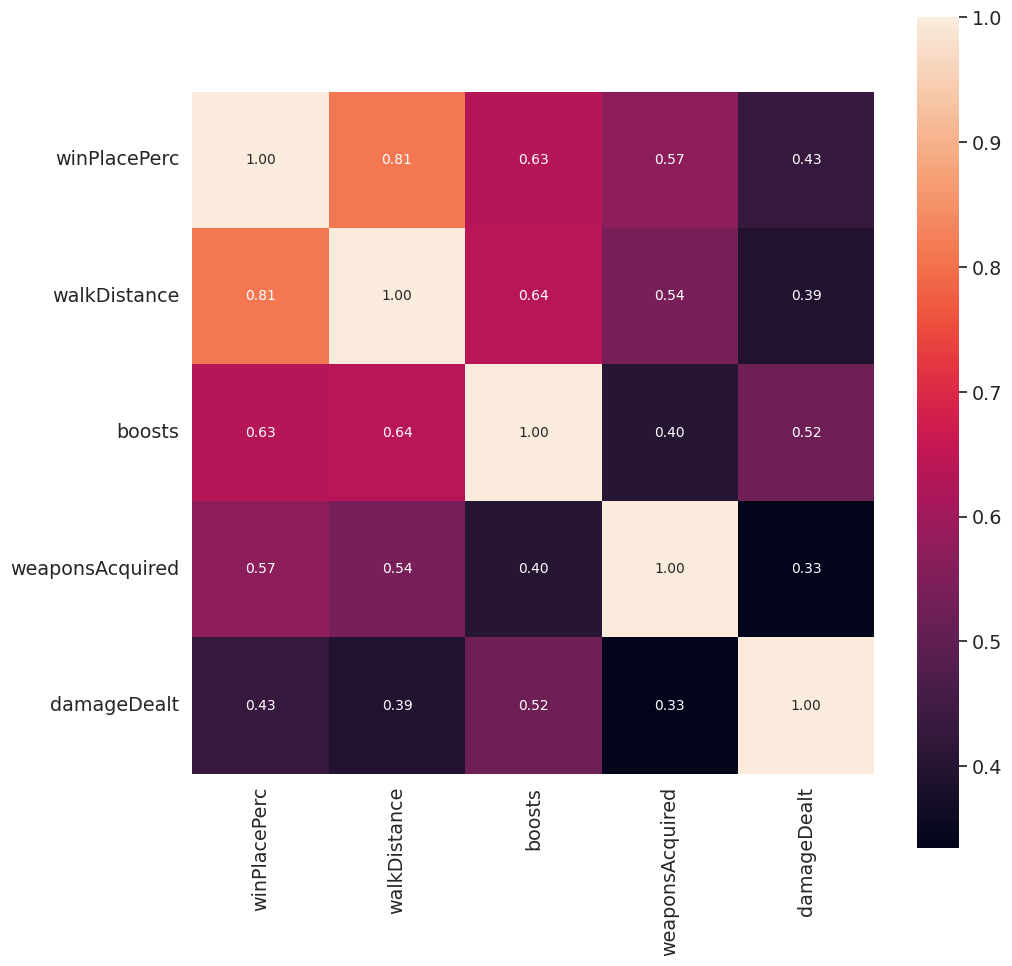

In [124]:
f,ax = plt.subplots(figsize=(11, 11))
cols = df.corr().nlargest(5, 'winPlacePerc')['winPlacePerc'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## New Features


We already created 'headshotPercentage' and 'totalDistance' features during cleaning stage. 

Now we will consider some other options.


### Players in match

This features will let as know how many people are in a match. Thanks to that we can normalize some features.

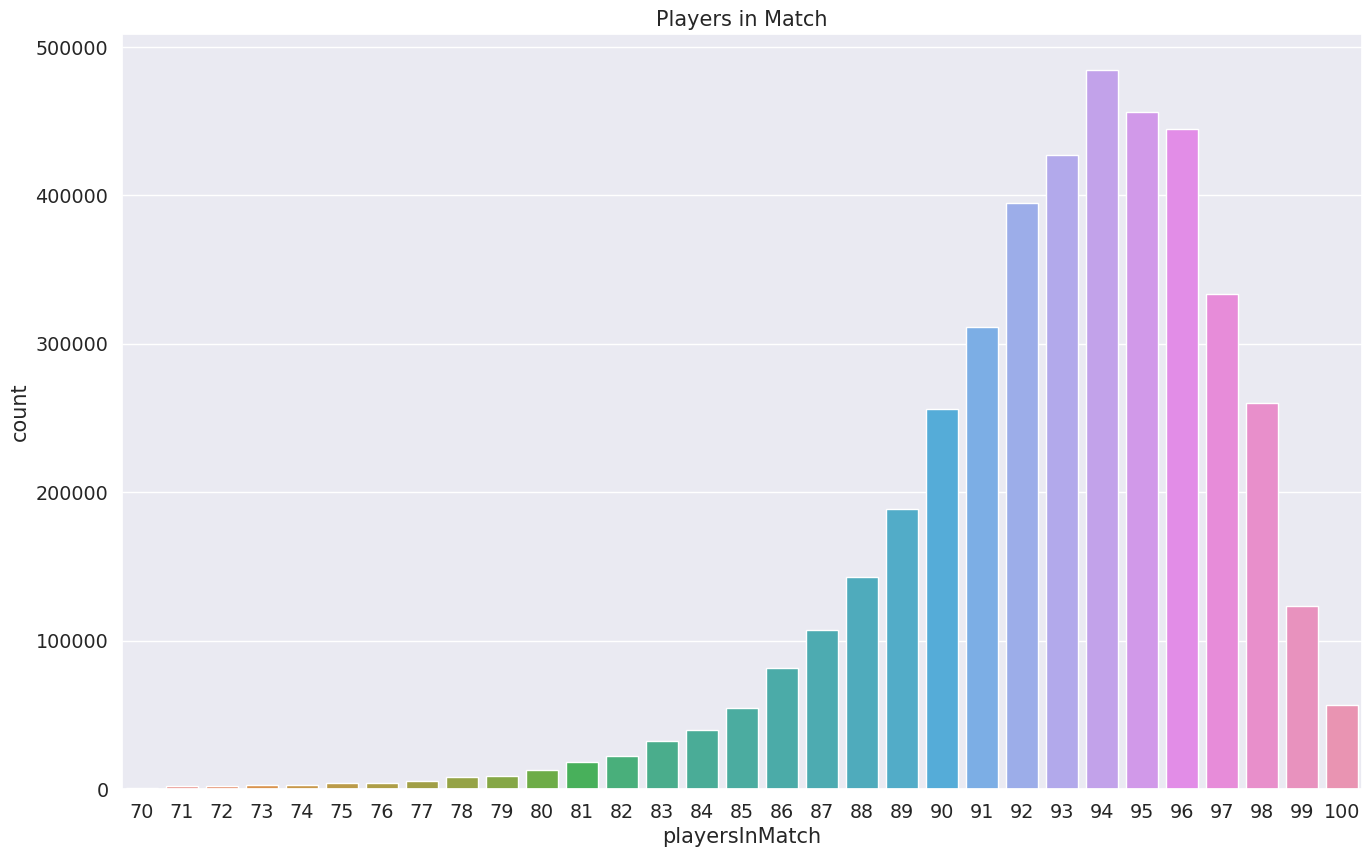

In [125]:
df['playersInMatch'] = df.groupby('matchId')['matchId'].transform('count')
plt.figure(figsize=(16,10))
sns.countplot(x=df[df['playersInMatch']>=70]['playersInMatch'])
plt.title('Players in Match')
plt.show()

Most of the matches are nearly full.


#### Normalization 

Based on the "playersInMatch" feature we can create (or change) a lot of others to normalize their values.
Since the number of players in game is not const and when there are 100players in the game it might be easier to find someone
we can create the "killsNorm", "damageDealtNorm"

In [126]:
df['killsNorm'] = df['kills']*((100-df['playersInMatch'])/100 + 1)
df['damageDealtNorm'] = df['damageDealt']*((100-df['playersInMatch'])/100 + 1)
df['assistsNorm'] = df['assists']*((100-df['playersInMatch'])/100 + 1)
df['DBNOsNorm'] = df['DBNOs']*((100-df['playersInMatch'])/100 + 1)

df[['playersInMatch', 'kills', 'killsNorm', 'damageDealt', 'damageDealtNorm', 'assists', 'assistsNorm', 'DBNOs', 'DBNOsNorm']].head()

,playersInMatch,kills,killsNorm,damageDealt,damageDealtNorm,assists,assistsNorm,DBNOs,DBNOsNorm
0,94,0,0.00,0.00000,0.000000,0,0.00,0,0.0
1,90,0,0.00,91.50000,100.650000,0,0.00,0,0.0
2,93,0,0.00,68.00000,72.760000,1,1.07,0,0.0
3,91,0,0.00,32.90625,35.867812,0,0.00,0,0.0
4,94,1,1.06,100.00000,106.000000,0,0.00,0,0.0


### Total Distance

In [ ]:
df['totalDistance'] = df['rideDistance'] + df['swimDistance'] + df['walkDistance']
df['totalDistance'].describe()

## Feature Importance

We will analyze importances of features
